# Notebook Description

Please note, we will not be doing any EDA in this notebook. For that please refer to my extensive EDA notebook in the Stroke Prediction series

Contents of this notebook :

1. Training Data Preparation
2. Baseline Models
3. Baseline Model Evaluation
4. Stacked Model
5. Final Evaluation and Result

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Libraries and Utilities 

In [2]:
import warnings
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report, roc_auc_score, roc_curve, auc






In [3]:

# Ignore warnings
warnings.filterwarnings("ignore")

In [4]:
df_raw = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df_raw.shape

(5110, 12)

# 1. Training Data Preparation

In [6]:
#dropping the id column as we will be using the default index 
df_raw.drop("id",axis = 1, inplace = True)

In [7]:
# using the wonderful piece of code from Thomas Konstantin's Notebook 
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df_raw[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df_raw.loc[Missing.index,'bmi'] = predicted_bmi

In the Extensive EDA, we decided to drop the columns - gender and ever married. We are going to keep the rest of the features.

In [8]:
#dropping Gender and ever_married
df_processed = df_raw.drop(columns = ['gender', 'ever_married'])

In [9]:
df_processed.shape

(5110, 9)

In [10]:
df_processed.head(2)

,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,61.0,0,0,Self-employed,Rural,202.21,29.879487,never smoked,1


Some ranting here:

I really wanted to try out **WOE Encoding or Weight of Evidence Encoding**. It's usually used in fraud prediction or credit risk models but it could have produced some great results here as it is especially well known for handling imbalanced datasets like this one. 

The only issue here is, I had to make the choice between WOE encoding or using **SMOTE** to create samples and mitigate the imbalance factor of the dataset. Now, these 2 things dont really go together. If I used WOE encoding and then used SMOTE, the interpolation can lead to nonsensical results. (eg WOE encoded value of Urban = -2.8 and Rural = +1.4, SMOTE can produce some weird number like 0.3 which would make no sense since its not any of the categories). 

Hence I had to choose one and I choose SMOTE. SMOTE is only compatible with one hot encoding, so thats what we are gonna do. 

In [11]:
df_processed['Residence_type'] = df_processed['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)

In [12]:
# One hot Encoding 
# Apply one-hot encoding to the specified column
# df_processed = pd.get_dummies(df_processed, columns=['smoking_status'], drop_first=True)

columns_to_encode = ['smoking_status','work_type']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)  
df_processed_final = encoder.fit_transform(df_processed[columns_to_encode])
encoded_columns = pd.DataFrame(df_processed_final, columns=encoder.get_feature_names_out(columns_to_encode))

# Concatenate the encoded columns with the original DataFrame
df_processed_final = pd.concat([df_processed.drop(columns=columns_to_encode), encoded_columns], axis=1)

In [13]:
df_processed_final.head()

,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67.0,0,1,1,228.69,36.600000,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,61.0,0,0,0,202.21,29.879487,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,0,105.92,32.500000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,49.0,0,0,1,171.23,34.400000,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,79.0,1,0,0,174.12,24.000000,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
df_processed_final.columns

Index(['age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children'],
      dtype='object')

SMOTE method

In [15]:
X  = df_processed_final[['age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children']]
y = df_processed_final['stroke']


In [16]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X, y.ravel())

In [17]:
X_train_resh = X_train_resh.values

The data imbalance is now mitigated. We can proceed with baseline Model Creation

In [18]:
# Standardizing the dataset after SMOTE
scaler = StandardScaler()

# Fit and transform X_train
X_train_scaled = scaler.fit_transform(X_train_resh)

In [19]:
print(X_train_scaled.shape)
print(y_train_resh.shape)

(9722, 13)
(9722,)


# 2. Baseline Models

The idea is to keep 20% of the data completely out of the training process as my final test set.
The rest of the 80% data will undergo training and it will be broken up into training and validation sets iterately during k fold cross validation. 

In [20]:
# Split into train, validation and test sets

# First, split into 70% training and 30% (temporary) for validation and test
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_train_scaled, y_train_resh, test_size=0.2, random_state=42)


# Check the shapes of the splits to verify
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (7777, 13)
X_test_final shape: (1945, 13)


In [21]:
# Some useful parameters which will come in handy later on

ntrain = X_train_final.shape[0]
ntest = X_test_final.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=42, params=None):
        # Check if the classifier accepts the `random_state` parameter
        if 'random_state' in clf().get_params():
            params['random_state'] = seed
        self.clf = clf(**params)

    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [22]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((kf.get_n_splits(), ntest))
    fold_scores = []  # Store scores for each fold

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

        # Evaluate performance on validation set
        fold_score = roc_auc_score(y_train[test_index], oof_train[test_index])  # ROC-AUC
        fold_scores.append(fold_score)

    oof_test[:] = oof_test_skf.mean(axis=0)
    print(f"Mean CV Score for {clf.clf.__class__.__name__}: {np.mean(fold_scores):.4f}")
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), fold_scores 

In [23]:
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

Ok Just a note Here, The code below has gone through several rounds of changes. I tried multiple baseline models, probably every single orthodox (simple) models you have heard of with the aim of getting a variety of weak learners which are different from each other. But from these iterations I realised the following things :

1. The particular dataset is actually pretty straightforward and doesnt really explicitly need the help of stacking weak learners. More complex datasets with complicated relationships and tons of features would benefit more from stacking. 
2. A normal Random Forest or GB Model with a good hyperparameter tuning would be capable of giving results close to 95 to 96% accuracy of test set.
3. Some models indiviually are giving decent results. For example, training a logistic regression indivually would give around 88% accuracy but when ensembled with other weak learners, it is actually decremental to the overal ensemble. Hence I removed Logistic, naive Bayes from the baseline Models.
4. Similarly Adaboost indiviually was giving an acuracy of 92% but when ensembled with other boosting and bagging algorithms, the correlation between them were too high and since my meta learner is a logistic regression, a linear alogirthm (as you will see below), we were getting hit with the collinearity problem. Hence I had to remove adaboost. But again Adaboost individually would do a pretty decent job.
5. We could ideally hit 98% accuracy (my estimation) on training set if we used a neural network as a meta learner, but I fear we could hit overfitting at some point. Hence tuning the neural network would be a headache. Also there is a genuine reasoning behind choosing a linear model as meta learner as you will see below.

I have finally selected the following set of models as my base learners :

- Random Forest
- K nearest Neighbours
- Extra Trees Classifier
- LightGBM 
- Gradient Boosting Classifier
- Support Vector Machine

In [24]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# # AdaBoost parameters
# ada_params = {
#     'n_estimators': 500,
#     'learning_rate' : 0.75
# }

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# # Logistic Regression Parameters
# lr_params = {
#     'C': 1.0,  
#     'penalty': 'l2',  
#     'solver': 'lbfgs',  
#     'max_iter': 1000 
# }

# K-Nearest Neighbors Parameters
knn_params = {
    'n_neighbors': 5, 
    'weights': 'uniform',  
    'algorithm': 'auto'  
}

# LightGBM Parameters
lgb_params = {
    'n_estimators': 500,
    'max_depth': -1,  
    'learning_rate': 0.05,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary',
    'random_state': SEED,
    'verbose' : 0
}



In [25]:
# creating 6 objects utlizing the sklearnHelperclass

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
knn = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_params)
lgb = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lgb_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)



Mean CV Score for ExtraTreesClassifier: 0.8891


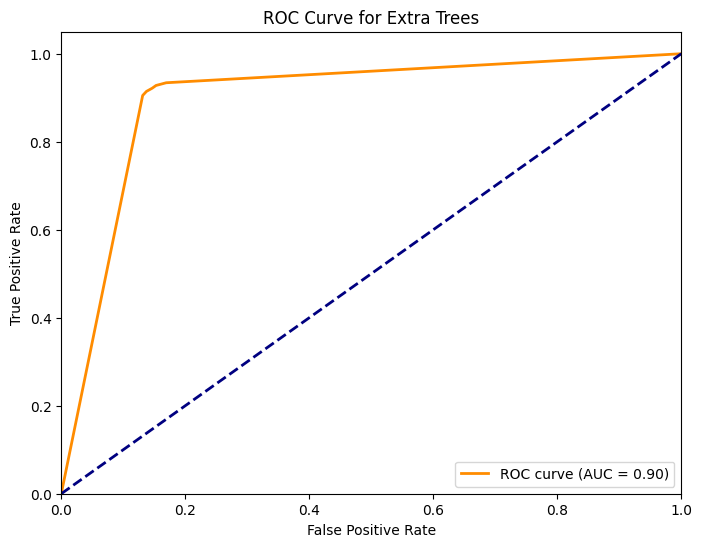

Mean CV Score for GradientBoostingClassifier: 0.9632


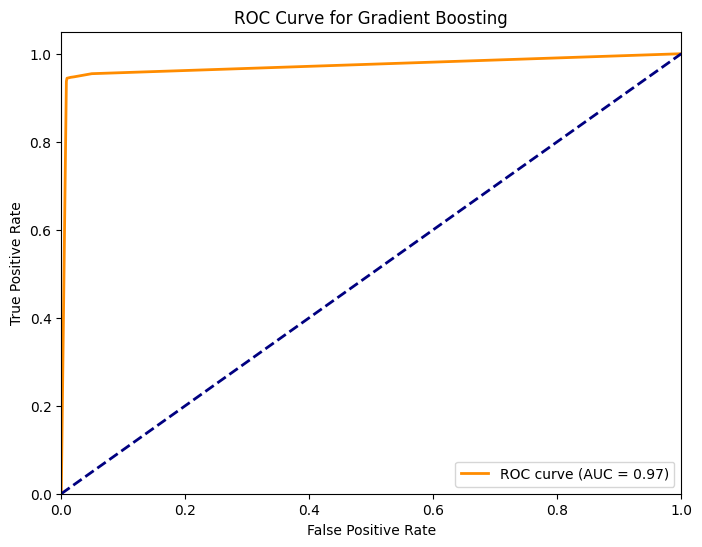

Mean CV Score for SVC: 0.7985


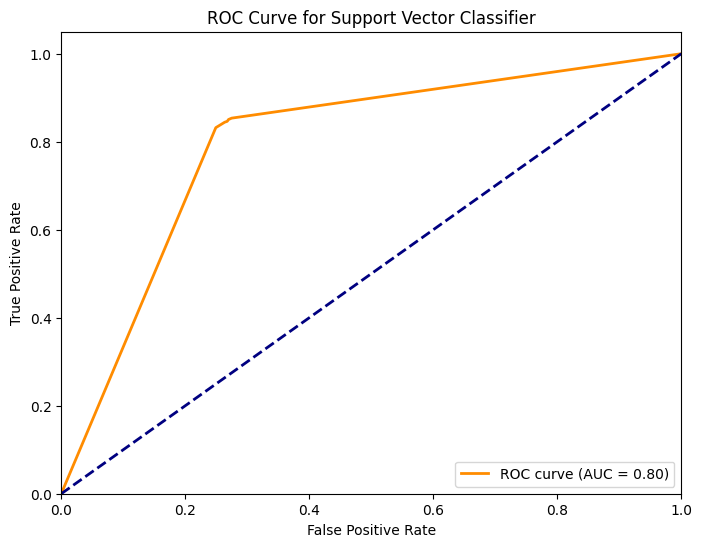

Mean CV Score for RandomForestClassifier: 0.9232


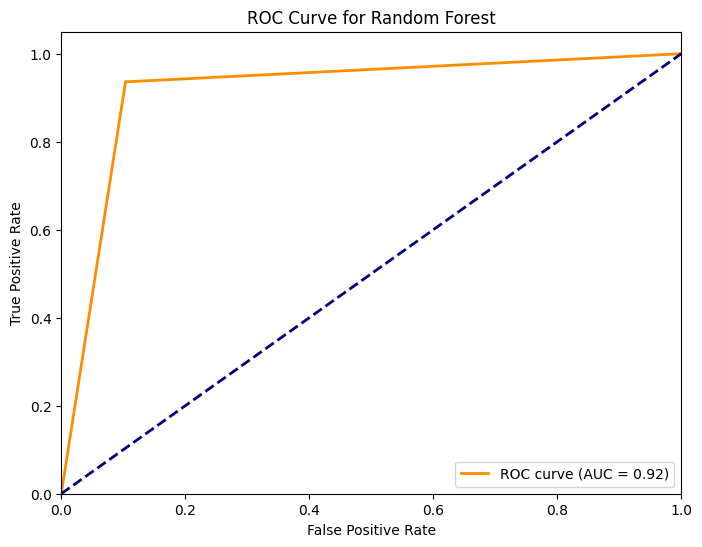

Mean CV Score for KNeighborsClassifier: 0.8989


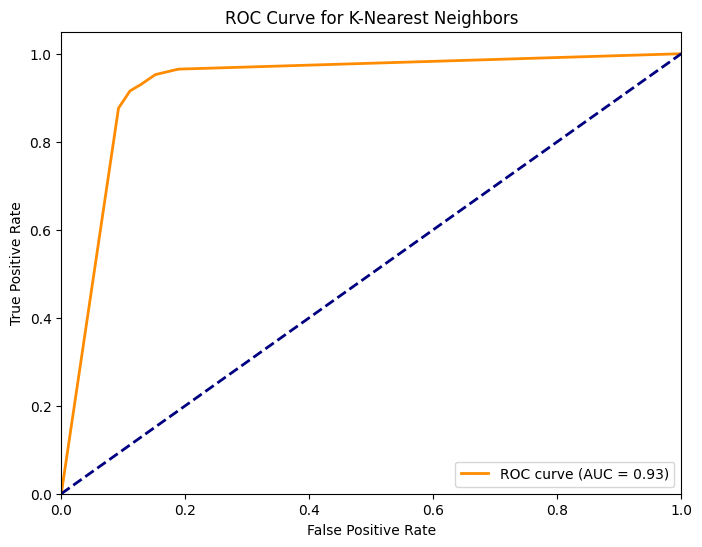

Mean CV Score for LGBMClassifier: 0.9638


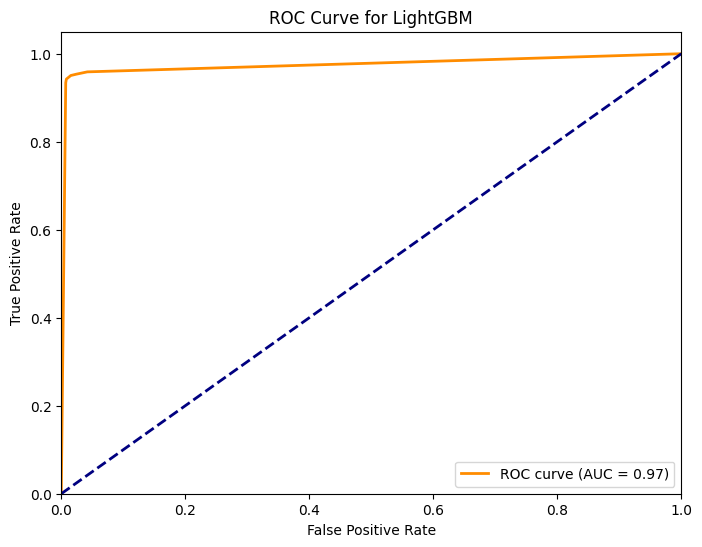

In [26]:
# Create OOF train and test predictions for all selected models
# OOF predictions for all models
et_oof_train, et_oof_test, et_scores = get_oof(et, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, et_oof_test.ravel(), "Extra Trees")

gb_oof_train, gb_oof_test, gb_scores = get_oof(gb, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, gb_oof_test.ravel(), "Gradient Boosting")

svc_oof_train, svc_oof_test, svc_scores = get_oof(svc, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, svc_oof_test.ravel(), "Support Vector Classifier")

rf_oof_train, rf_oof_test, rf_scores = get_oof(rf, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, rf_oof_test.ravel(), "Random Forest")

knn_oof_train, knn_oof_test, knn_scores = get_oof(knn, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, knn_oof_test.ravel(), "K-Nearest Neighbors")

lgb_oof_train, lgb_oof_test, lgb_scores = get_oof(lgb, X_train_final, y_train_final, X_test_final)
plot_roc_curve(y_test_final, lgb_oof_test.ravel(), "LightGBM")

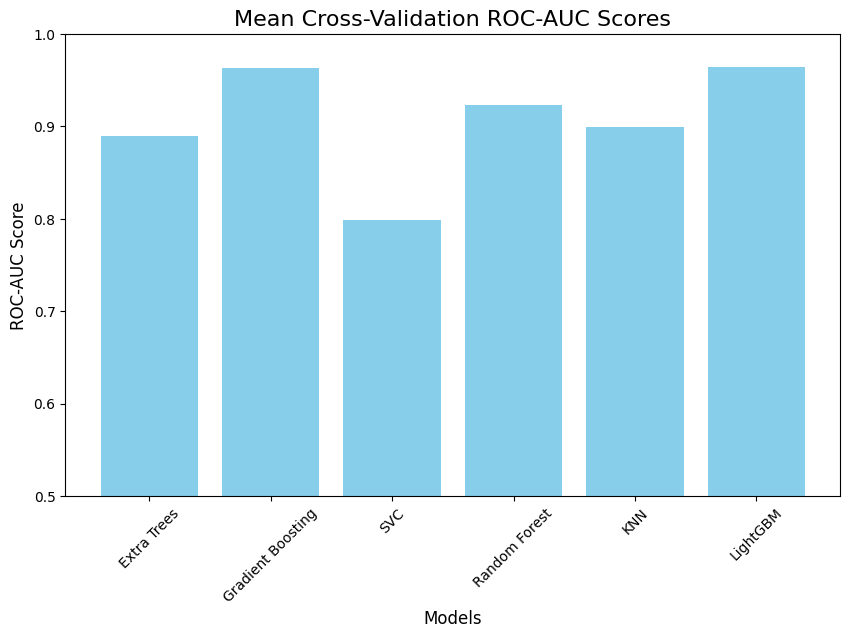

In [27]:
# Updated models and their mean CV scores
models = ['Extra Trees', 'Gradient Boosting', 'SVC', 'Random Forest', 'KNN', 'LightGBM']
mean_scores = [
    np.mean(et_scores),
    np.mean(gb_scores),
    np.mean(svc_scores),
    np.mean(rf_scores),
    np.mean(knn_scores),
    np.mean(lgb_scores),
]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.bar(models, mean_scores, color='skyblue')
plt.title('Mean Cross-Validation ROC-AUC Scores', fontsize=16)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0.5, 1.0)  # Adjust based on expected range
plt.xticks(rotation=45)
plt.show()


#### Inference From Baselines: 
Ensemble methods, particularly Boosting methods are clearly the way to go for this algorithm. Might have been a good idea to through in a basic neural network there, but I feel tree based methods would generally produce better results for this kind of problem. 

*Some More Important points to consider *

Notice how I selected these algorithms. Random Forest is really good for handling overfitting problems. LightGBM and Grad boost uses weak learners, SVC is a linear kernel which introduces more variablity in the ensemble of algorithms I am trying to create. Basically I feel when we are trying to stack algorithms it is usually better to select algorithms with various backgrounds and utlity so that when we average it, it represents a true ensemble. If that makes sense. 

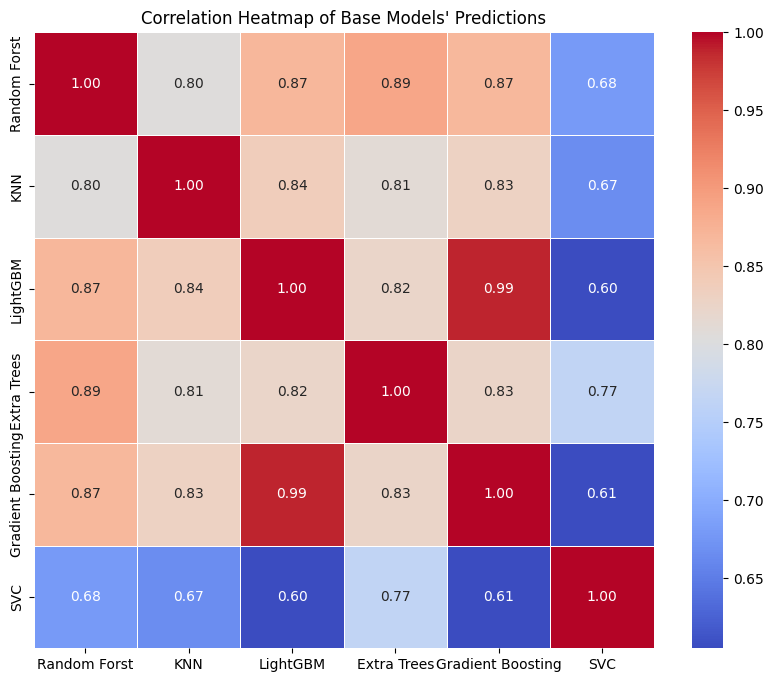

In [28]:
# Combine OOF predictions into a DataFrame
oof_df = pd.DataFrame({
    "Random Forst": rf_oof_test.flatten(),
    "KNN": knn_oof_test.flatten(),
    "LightGBM": lgb_oof_test.flatten(),
    "Extra Trees": et_oof_test.flatten(),
    "Gradient Boosting": gb_oof_test.flatten(),
    "SVC": svc_oof_test.flatten()
})

# Compute the correlation matrix
correlation_matrix = oof_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Base Models' Predictions")
plt.show()


The heatmap above tells us how each base learner is correlated with each other. As expected, the ensemble algorithms (rf, lgbm, gbm , et) have high correlation. I tried skipping a few but the final meta accuracy drops so had to keep them even with high correlation. However the KNN and SVC is creating just the right amount of diversity. 

# Training Meta Model - Second Level Model

In [29]:
# Combine OOF predictions for the training set

base_predictions_train = np.concatenate((
    rf_oof_train,  # Random Forest
    knn_oof_train,  # K-Nearest Neighbors
    lgb_oof_train,  # LightGBM
    et_oof_train,  # Extra Trees
    gb_oof_train,  # Gradient Boosting
    svc_oof_train  # Support Vector Classifier
), axis=1)

# Combine OOF predictions for the test set
base_predictions_test = np.concatenate((
    rf_oof_test,  # Random Forest
    knn_oof_test,  # K-Nearest Neighbors
    lgb_oof_test,  # LightGBM
    et_oof_test,  # Extra Trees
    gb_oof_test,  # Gradient Boosting
    svc_oof_test  # Support Vector Classifier
), axis = 1)

In [30]:
base_predictions_train.shape

(7777, 6)

In [31]:
# Meta model - Logistic Regression

meta_clf = LogisticRegression(random_state=SEED)
meta_clf.fit(base_predictions_train, y_train_final)
final_predictions = meta_clf.predict(base_predictions_test)

Why Logistic as meta learner ?

I will explain later ...

In [32]:
print(f"Accuracy: {accuracy_score(y_test_final, final_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_final, final_predictions):.4f}")
print(classification_report(y_test_final, final_predictions))

Accuracy: 0.9656
AUC-ROC: 0.9655
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       975
           1       0.98      0.95      0.96       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



Note in this problem, since we are predicting strokes, we would ideally want to reduce False Negetives that is we would be ok with classifying a person who wont have a stroke as stroke prone but It will be bad if we classify a stroke prone person as healthy (non- stroke prone) i.e False Negative. Hence our main focus on this problem should be **Recall** not Precision. 

In [33]:
# this code is telling us how each baseline model is contributing to meta model
print(f"Meta-model coefficients: {meta_clf.coef_}")

Meta-model coefficients: [[ 1.10827462  1.52207199  2.75432934  0.14886412  2.51881949 -0.15010214]]


##### Yes, this is precisely why I chose Logistic Regression as my meta-learner. Its linear nature allows me to directly interpret the coefficients, providing clear insights into how each baseline model contributes to the final predictions. If I had used a non-linear model like Random Forest or XGBoost, the contributions of the base models would essentially remain a black box.

##### With this transparency, I can make informed decisions, such as dropping underperforming models or fine-tuning the ones with lower contributions. However, for this particular problem, I don't think that's necessary since I’m quite satisfied with the overall performance of the stacked model.

# Final Conlusion 

### This was a good project to show how to implement Model Stacking from scratch. Is model stacking explicitly required for this dataset ? No. A normal boosting technique like LightGBM (My fav algo) or GBM would give very good results. Is stacking bad for this problem ? No. As you can see from above classification report, stacking is actually improving the recall i.e the stacked model recall is higher than any of the base models. Hence Overall I would say Stacking was a success even though the improvement is quite Marginal. 

# THE END